#Introduction

The Milan, Italy mobile phone activity dataset is a part of the Telecom Italia Big Data Challenge 2014, which is a rich and open multi-source aggregation of telecommunications, weather, news, social networks and electricity data from the city of Milan and the Province of Trentino (Italy).  

A complete version of the dataset  along with the original paper presenting the data can be found here: http://go.nature.com/2fz4AFr

Below I present analysis and modeling of the internet usage in Milan from November 1-7, 2014. 

## Data Read
Here we're using Pandas to import the Call Detail Records (CDR) for 10,000 cells across Milan. A Call Detail Record contains phone call, sms and internet connection data. In this notebook I'm focusing on the internet connection data. 

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

plt.rcParams['font.size'] = 14

sns.set_style("ticks")
sns.set_context("paper")

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output
print(check_output(["ls", "../input"]).decode("utf8"))

# Any results you write to the current directory are saved as output.

ISTAT_census_variables_2011.csv
Italian_provinces.geojson
mi-to-provinces-2013-11-01.csv
mi-to-provinces-2013-11-02.csv
mi-to-provinces-2013-11-03.csv
mi-to-provinces-2013-11-04.csv
mi-to-provinces-2013-11-05.csv
mi-to-provinces-2013-11-06.csv
mi-to-provinces-2013-11-07.csv
milano-grid.geojson
sms-call-internet-mi-2013-11-01.csv
sms-call-internet-mi-2013-11-02.csv
sms-call-internet-mi-2013-11-03.csv
sms-call-internet-mi-2013-11-04.csv
sms-call-internet-mi-2013-11-05.csv
sms-call-internet-mi-2013-11-06.csv
sms-call-internet-mi-2013-11-07.csv



In [2]:
df_cdrs = pd.DataFrame({})
for i in range(1,8):
    df = pd.read_csv('../input/sms-call-internet-mi-2013-11-0{}.csv'.format(i), parse_dates=['datetime'])
    df_cdrs = df_cdrs.append(df)
    
df_cdrs=df_cdrs.fillna(0)
df_cdrs['sms'] = df_cdrs['smsin'] + df_cdrs['smsout']
df_cdrs['calls'] = df_cdrs['callin'] + df_cdrs['callout']
df_cdrs.head()

df_cdrs_internet = df_cdrs[['datetime', 'CellID', 'internet', 'calls', 'sms']].groupby(['datetime', 'CellID'], as_index=False).sum()
df_cdrs_internet['hour'] = df_cdrs_internet.datetime.dt.hour+24*(df_cdrs_internet.datetime.dt.day-1)
df_cdrs_internet = df_cdrs_internet.set_index(['hour']).sort_index()



###Exploratory Analysis 

**Internet Activity Map**

Now let's map out internet activity in Milan. Plotting the temporally averaged internet connections for each cell. Averaged over the entire week (Nov. 1-7).

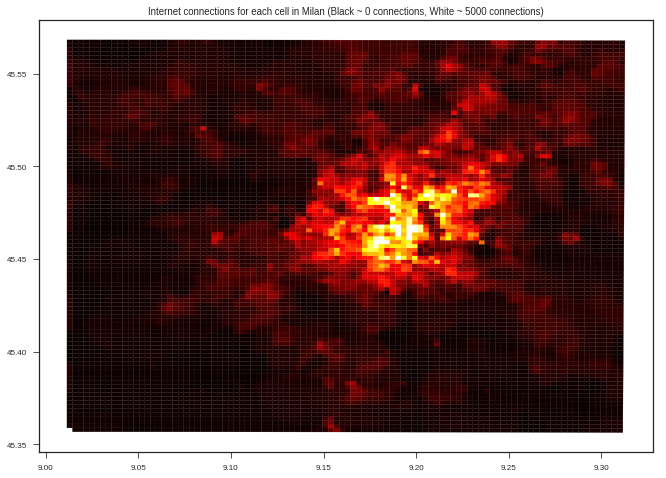

In [3]:
import geojson
import matplotlib.colors as colors
import matplotlib.cm as cmx
#import matplotlib as mpl
from descartes import PolygonPatch

num = int(10000+1)
arr_cellID = np.zeros(num)
arr_mean = np.zeros(num)
for i in range(1,num):
    ydata = df_cdrs_internet[df_cdrs_internet.CellID==i]['internet']
    xdata = df_cdrs_internet[df_cdrs_internet.CellID==i]['internet'].index
    mean = np.mean(ydata)
    arr_cellID[i]=i
    arr_mean[i]=mean

arr_mean[arr_mean<=0] = 1 #replacing 0's with 1's for log calc
arr_mean_log = np.log(arr_mean)

#https://gis.stackexchange.com/questions/93136/how-to-plot-geo-data-using-matplotlib-python
with open("../input/milano-grid.geojson") as json_file:
    json_data = geojson.load(json_file)
    

fig = plt.figure() 
ax = fig.gca() 

coordlist = json_data.features[1]['geometry']['coordinates'][0]

jet = cm = plt.get_cmap('hot') 
#cNorm  = colors.Normalize(vmin=0, vmax=np.max(arr_mean))
cNorm  = colors.Normalize(vmin=0, vmax=5000)
#cNorm  = colors.Normalize(vmin=0, vmax=np.max(arr_mean_log))
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
#print(scalarMap.get_clim())

for i in range(1,10000):
    poly = json_data.features[i]['geometry']
    colorVal = scalarMap.to_rgba(arr_mean[i])
    ax.add_patch(PolygonPatch(poly, fc=colorVal, ec=colorVal, alpha=1, zorder=1 ))
ax.axis('scaled')

fig.set_size_inches(11,11)
plt.title("Internet connections for each cell in Milan (Black ~ 0 connections, White ~ 5000 connections)")
plt.show()

We can see the hot spots for internet activity occur near the city center with a significant reduction in activity as you go further from the center. 

**Internet activity in time - Duomo**

Now let's look at internet activity vs. time for a single cell. Here I'm focusing on the Duomo (downtown) district in the city, Cell #5060. This is the location for the cathedral containing Leonardo da Vinci's The Last Supper painting (Duomo di Milano Italia).

There's clearly a periodic nature to the number of internet connections. By inspection the period is ~24 hrs. Not surprising.

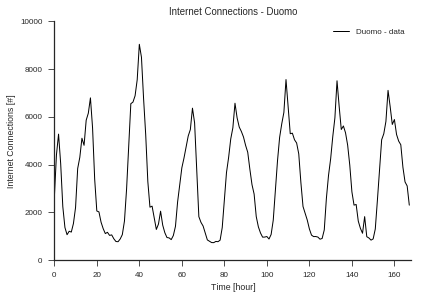

In [4]:

#Duomo (downtown) data
ydata = df_cdrs_internet[df_cdrs_internet.CellID==5060]['internet']
xdata = df_cdrs_internet[df_cdrs_internet.CellID==5060]['internet'].index

f = plt.figure()
plt.plot(xdata, ydata, color='black', linewidth=1, linestyle='-', label='Duomo - data')
plt.title("Internet Connections - Duomo")
plt.xlabel("Time [hour]")
plt.ylabel("Internet Connections [#]")
plt.xlim([0,168])
plt.ylim([0,10000])
plt.legend()
sns.despine()
plt.show()

**Autocorrelation**

Now let's perform an autocorrelation calculation on the Duomo data.


/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


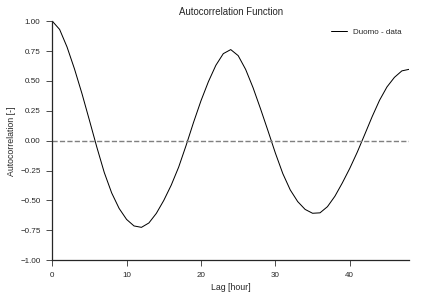

In [5]:
# Autocorellation (ACF) calc
from statsmodels.tsa.stattools import acf, pacf
acf_y = acf(ydata, nlags=48)

#Plot ACF: 
f = plt.figure()
plt.plot(acf_y, color='black', linewidth=1, linestyle='-', label='Duomo - data')
plt.axhline(y=0,linestyle='--',color='gray')
plt.title('Autocorrelation Function')
plt.xlabel("Lag [hour]")
plt.ylabel("Autocorrelation [-]")
plt.xlim([0,48])
plt.ylim([-1,1])
plt.legend()
sns.despine()
plt.show()

The Autocorrelation Function shows the very strong correlation at a lag of 24 hrs, which is consistent with visual observation of a 24 hr period in the internet activity. 

###Modeling Internet Usage
Here I propose a model for the internet activity. The model assumes sinusoidal behavior for internet activity with a period of 24 hrs.

**Model for Duomo data**

I'm using SciPy's curve fit method to fit a sin curve with a period of 24 hrs. to the Duomo data.


In [6]:
import scipy
def func(xdata, a,b,c):
    return a*np.sin(2*np.pi*(1/24)*xdata+b)+c

In [7]:
popt,pcov = scipy.optimize.curve_fit(func, xdata, ydata)

print(popt)

f = plt.figure()
yfit = func(xdata, *popt)
#residual
residual = ydata - yfit
rss = np.sum(residual**2)
mean = np.mean(ydata)
b = popt[1] #phase shift (b) from curve_fit
#print('rss_navigli',rss_navigli,'mean_navigli',mean_navigli,'rss-norm',rss_navigli/mean_navigli)
#stddev = np.std(residual_navigli)
#print(np.std(residual_navigli))

yfit_duomo = yfit
b_duomo = b
ydata_duomo = ydata
xdata_duomo = xdata
T_peak_duomo = 18-(b_duomo%(2*np.pi))*(24/(2*np.pi))

ydata_moving_avg = ydata.rolling(window=24,center=False).mean()
residual_moving_avg = residual.rolling(window=24,center=False).mean()



[-2618.96926168    19.64212211  3269.20666607]


The sine model appears to be a reasonable fit to the Duomo data. 

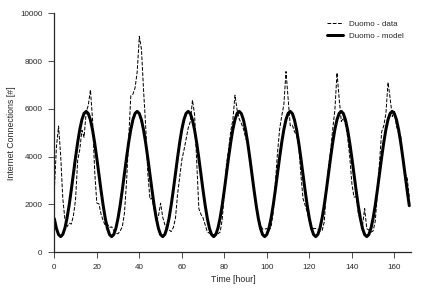

In [8]:

f = plt.figure()
plt.plot(xdata, ydata, color='black', linewidth=1, linestyle='--', label='Duomo - data')
plt.plot(xdata, yfit, color='black', linewidth=3, label='Duomo - model')
plt.xlabel("Time [hour]")
plt.ylabel("Internet Connections [#]")
plt.xlim([0,168])
plt.ylim([0,10000])
plt.legend()
sns.despine()
plt.show()

**Residual analysis**
An effective time series model captures trends and seasonality in the data, with only random noise left as a residual (the difference between raw data and the model). Data that is truly random noise can be classified as statistically stationary and modeled stochastically.

Next we'll analyze the residual to determine if it is statically stationary, which will tells us how effective our model is.

Here's a plot of the residual. Looks pretty random to me.

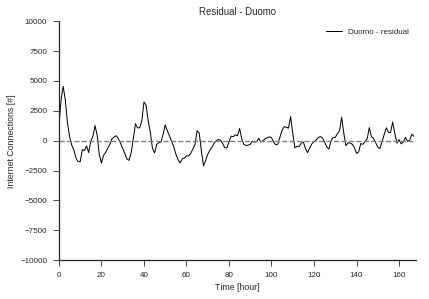

In [9]:
ff = plt.figure()
plt.plot(xdata, residual, color='black', linewidth=1, linestyle='-', label='Duomo - residual')
plt.axhline(y=0,linestyle='--',color='gray')
plt.title("Residual - Duomo")
plt.xlabel("Time [hour]")
plt.ylabel("Internet Connections [#]")
plt.xlim([0,168])
plt.ylim([-10000,10000])
plt.legend()
sns.despine()
plt.show()

**Residual Autocorrelation**

The Autocorrelation calculation of the residual gives us more clues on the statistical nature of the residual. For completely random, statistically stationary data the strongest correlation exists at lag=0 and decreases as lag increases.

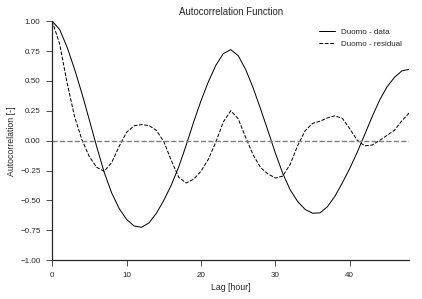

In [10]:
#Plot ACF: 
from statsmodels.tsa.stattools import acf, pacf
acf_r = acf(residual, nlags=48)

f = plt.figure()

plt.plot(acf_y, color='black', linewidth=1, linestyle='-', label='Duomo - data')
plt.plot(acf_r, color='black', linewidth=1, linestyle='--', label='Duomo - residual')

plt.axhline(y=0,linestyle='--',color='gray')
plt.title('Autocorrelation Function')
plt.xlabel("Lag [hour]")
plt.ylabel("Autocorrelation [-]")
plt.xlim([0,48])
plt.ylim([-1,1])
plt.legend()
sns.despine()
plt.show()

We can see that only a weak correlation remains at 24 (and 12) hours in our residual. This is contrasted by strong correlations observed in the raw data. This suggests that we're pretty close to having a statistically stationary residual, which is the goal in our modeling efforts.

**Dickey-Fuller Stationarity Test**

A quantitative test to determine if our residual is actually statistically stationary is the Dickey-Fuller unit root test.

The NULL hypothesis is that the data is NOT statistically stationary. The test statistic indicates how likely we are to reject the NULL hypothesis and say the residual is statistically stationary. The more negative the test statistic the more likely we are to reject the NULL. 

In this case the test statistic is about -7 with the critical value of -2.9 (5% CI). This means that we can reject the NULL hypothesis and say with 95% confidence that the residual is indeed statistically stationary.  

Conclusion: our simple sine model is good for the Duomo region of Milan!

https://www.thoughtco.com/the-augmented-dickey-fuller-test-1145985

In [11]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries,maxlag_input=None):
    #https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC', maxlag=maxlag_input)
    #print(dftest)
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput) 


test_stationarity(residual,1)

Results of Dickey-Fuller Test:
Test Statistic                -7.405407e+00
p-value                        7.367270e-11
#Lags Used                     1.000000e+00
Number of Observations Used    1.660000e+02
Critical Value (1%)           -3.470370e+00
Critical Value (5%)           -2.879114e+00
Critical Value (10%)          -2.576139e+00
dtype: float64


**Modelling all 10,000 cells**

Now let's apply this model across all 10,000 cells!

In [12]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity2(timeseries,maxlag_input=None):
    #modifying method - removing prints, return key values
    #https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/
    #Perform Dickey-Fuller test:
    dftest = adfuller(timeseries, autolag='AIC', maxlag=maxlag_input)
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    return dftest

num = int(10000+1)
#num = int(10+1)
arr_cellID = np.zeros(num)
arr_mean = np.zeros(num)
arr_rss = np.zeros(num)
arr_rss_norm = np.zeros(num)
arr_test_statistic = np.zeros(num)
arr_critical_value = np.zeros(num)
arr_stationary = np.zeros(num)
arr_T_peak = np.zeros(num)
arr_a_norm = np.zeros(num)


for i in range(1,num):
    ydata = df_cdrs_internet[df_cdrs_internet.CellID==i]['internet']
    xdata = df_cdrs_internet[df_cdrs_internet.CellID==i]['internet'].index
    
    #print(ydata)
    
    #sine fit
    popt,pcov = scipy.optimize.curve_fit(func, xdata, ydata)
    
    #
    yfit = func(xdata, *popt)
    
    a=popt[0]
    b=popt[1]
    c=popt[2]
    
    #residual
    residual = ydata - yfit
    rss = np.sum(residual**2)
    mean = np.mean(ydata)
    rss_norm = rss/mean
    #print('rss',rss,'mean',mean,'rss-norm',rss_norm)
    
    #Dickey-Fuller test
    #lag = 1 - using original (not augmented) Dickey-Fuller
    result = test_stationarity2(residual,1)
    test_statistic = result[0]
    critical_value = result[4]['5%']
    stationary = bool(test_statistic<critical_value)

    if (a>0) :
        T_peak = 6+24-(b%(2*np.pi))*(24/(2*np.pi))
    elif (a<=0) :
        T_peak = 18-(b%(2*np.pi))*(24/(2*np.pi))
    T_peak = T_peak%24 

    a_norm = np.abs(a/c)
    
    arr_cellID[i]=i
    arr_mean[i]=mean
    arr_rss[i]=rss
    arr_rss_norm[i]=rss_norm
    arr_test_statistic[i]=test_statistic
    arr_critical_value[i]=critical_value
    arr_stationary[i]=stationary
    arr_T_peak[i]=T_peak
    arr_a_norm[i]=a_norm
    

###Peak Internet Analysis

We've now applied the model to all 10,000 cells. Let's look and see what else we can learn about internet usage in Milan.

Below shows raw and modeled internet usage for the Duomo (downtown) district and Navigli (Night life) district of Milan.  

In [13]:

# Navigli
ydata = df_cdrs_internet[df_cdrs_internet.CellID==4456]['internet']
xdata = df_cdrs_internet[df_cdrs_internet.CellID==4456]['internet'].index


popt,pcov = scipy.optimize.curve_fit(func, xdata, ydata)

print(popt)

f = plt.figure()
yfit = func(xdata, *popt)
#residual
residual = ydata - yfit
rss = np.sum(residual**2)
mean = np.mean(ydata)
a = popt[0] #amplitude
b = popt[1] #phase shift (b) from curve_fit
c = popt[2] #mean

yfit_navigli = yfit
b_navigli = b
ydata_navigli = ydata
xdata_navigli = xdata

if (a>0) :
    T_peak = 6+24-(b%(2*np.pi))*(24/(2*np.pi))
elif (a<=0) :
    T_peak = 18-(b%(2*np.pi))*(24/(2*np.pi))
T_peak = T_peak%24 

a_norm = np.abs(a/c)

print (a_norm)

T_peak_navigli = T_peak    
print(T_peak_duomo)
print(T_peak_navigli)

[ 1418.29044147    40.91815555  4089.87653012]
0.346780747787
14.9726201716
17.7041587767


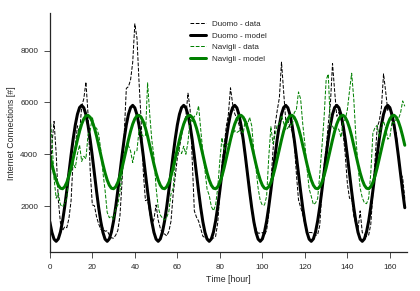

In [14]:
f = plt.figure()
plt.plot(xdata_duomo, ydata_duomo, color='black', linewidth=1, linestyle='--', label='Duomo - data')
plt.plot(xdata_duomo, yfit_duomo, color='black', linewidth=3, label='Duomo - model')
plt.plot(xdata_navigli, ydata_navigli, color='green', linewidth=1, linestyle='--', label='Navigli - data')
plt.plot(xdata_navigli, yfit_navigli, color='green', linewidth=3, label='Navigli - model')

plt.xlabel("Time [hour]")
plt.ylabel("Internet Connections [#]")
plt.xlim([0,168])
plt.legend()
sns.despine()

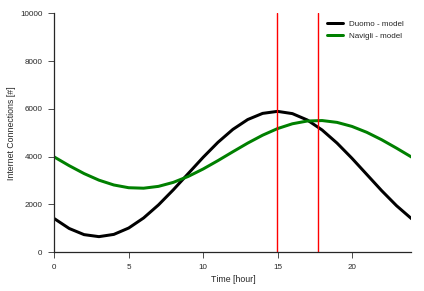

In [15]:
f = plt.figure()
#plt.plot(xdata_duomo, ydata_duomo, color='black', linewidth=1, linestyle='--', label='Duomo - data')
plt.plot(xdata_duomo, yfit_duomo, color='black', linewidth=3, label='Duomo - model')
#plt.plot(xdata_navigli, ydata_navigli, color='green', linewidth=1, linestyle='--', label='Navigli - data')
plt.plot(xdata_navigli, yfit_navigli, color='green', linewidth=3, label='Navigli - model')
plt.axvline(x=T_peak_duomo, color='red')
plt.axvline(x=T_peak_navigli, color='red')

plt.xlabel("Time [hour]")
plt.ylabel("Internet Connections [#]")
plt.xlim([0,24])
plt.ylim([0,10000])
plt.legend()
sns.despine()

We can see that peak usage (from the model) occurs at roughly hour 14 (2pm) in Duomo and roughly hour 18 (6pm) in Navigli. 

This is intuitive as we would expect downtown areas to be fairly empty in the evening while areas of night life having more activity late into the evening, pushing peak usage to later in the evening.


**Map of peak usage**

Here we're plotting the peak internet usage from our model across Milan. We can see that the majority of cells have peak usage in the middle of the day (black to red) with a few clusters showing peak usage that has shifted into the evening (orange to white).

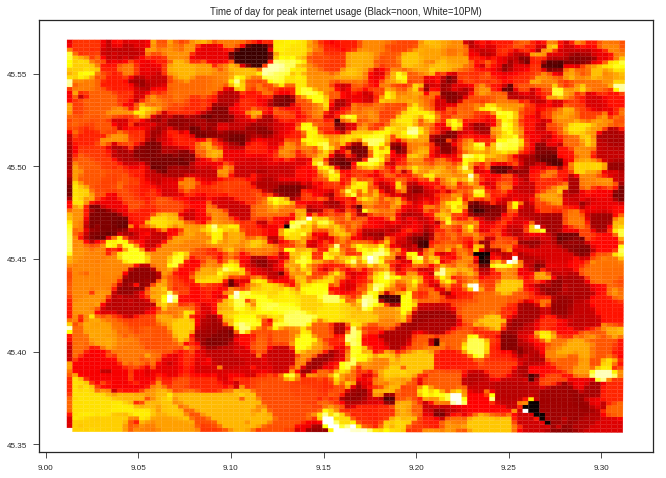

In [16]:
fig = plt.figure() 
ax = fig.gca() 

jet = cm = plt.get_cmap('hot') 
cNorm  = colors.Normalize(vmin=12, vmax=20)
#cNorm  = colors.Normalize(vmin=0, vmax=np.max(arr_T_peak))
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)

for i in range(1,10000):
    poly = json_data.features[i]['geometry']
    colorVal = scalarMap.to_rgba(arr_T_peak[i])
    ax.add_patch(PolygonPatch(poly, fc=colorVal, ec=colorVal, alpha=1, zorder=2 ))
ax.axis('scaled')
plt.title("Time of day for peak internet usage (Black=noon, White=10PM)")
fig.set_size_inches(11,11)
plt.show()

###Amplitude Analysis
Now let's look at the relative peaks/valleys observed in usage. The comparison between the Duomo and Navigli models shows very different deltas in the peak/off-peak usage.
Dumo shows large swings in internet usage while Navigli shows gentler swings between peak/off-peak times.

We quantify this by computing the ratio of amplitude and mean from our model (Amplitude/mean). 

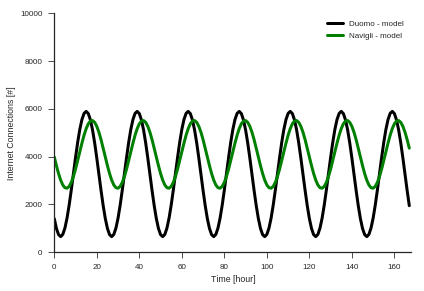

In [17]:
f = plt.figure()
#plt.plot(xdata_duomo, ydata_duomo, color='black', linewidth=1, linestyle='--', label='Duomo - data')
plt.plot(xdata_duomo, yfit_duomo, color='black', linewidth=3, label='Duomo - model')
#plt.plot(xdata_navigli, ydata_navigli, color='green', linewidth=1, linestyle='--', label='Navigli - data')
plt.plot(xdata_navigli, yfit_navigli, color='green', linewidth=3, label='Navigli - model')

plt.xlabel("Time [hour]")
plt.ylabel("Internet Connections [#]")
plt.xlim([0,168])
plt.ylim([0,10000])
plt.legend()
sns.despine()

**map showing the amplitude/mean ratio** 

High values (orange to white) means to large variations between peak/off-peak usage. These are likely areas with large swings in people throughout a single day (e.g. Duomo).
 
Low values (black to red) means gentler variations between peak/off-peak usage. These are likely areas with more constant internet usage (e.g. Navigli).

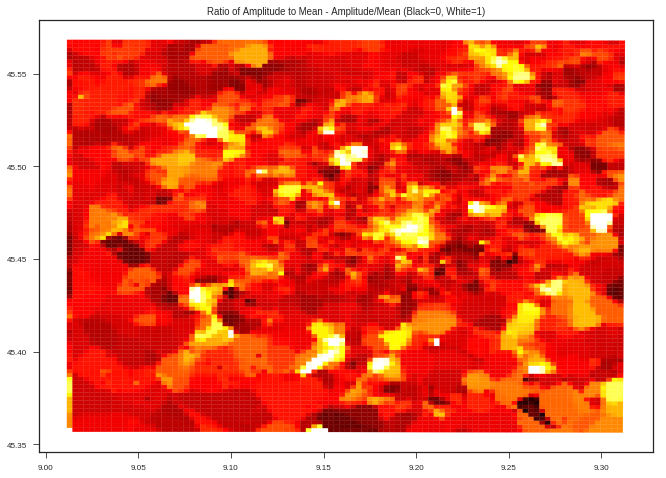

In [18]:
fig = plt.figure() 
ax = fig.gca() 

jet = cm = plt.get_cmap('hot') 
cNorm  = colors.Normalize(vmin=0, vmax=1)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)

for i in range(1,10000):
    poly = json_data.features[i]['geometry']
    colorVal = scalarMap.to_rgba(arr_a_norm[i])
    ax.add_patch(PolygonPatch(poly, fc=colorVal, ec=colorVal, alpha=1, zorder=1 ))
ax.axis('scaled')
#ax.colorbar(jet, ticks=[0, 1], orientation='horizontal')

#cbar = plt.colorbar(cNorm)
#cbar.ax.set_ylabel('verbosity coefficient')
# Add the contour line levels to the colorbar
#cbar.add_lines(CS2)
plt.title("Ratio of Amplitude to Mean - Amplitude/Mean (Black=0, White=1)")
fig.set_size_inches(11,11)
plt.show()

###Model Validation

We've looked at two cells where the model appears to behave well. Let's see how it behaves for the remaining 9,998 cells. 

**Model for Bocconi data**

The model does have issues with some cells. For example, let's look at the Cell ID for the Bocconi (university) district. 

In [19]:
#Bocconi
ydata = df_cdrs_internet[df_cdrs_internet.CellID==4259]['internet']
xdata = df_cdrs_internet[df_cdrs_internet.CellID==4259]['internet'].index

popt,pcov = scipy.optimize.curve_fit(func, xdata, ydata)
print(popt)

yfit = func(xdata, *popt)
residual = ydata - yfit


[-1089.32826926     7.21759345  1717.63656374]


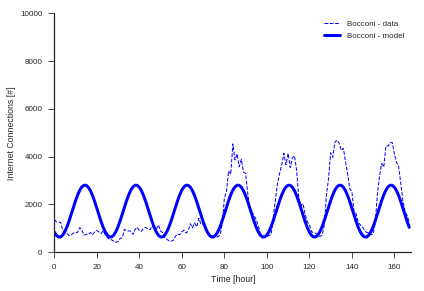

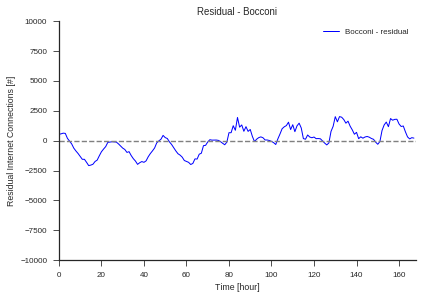

In [20]:
f = plt.figure()
plt.plot(xdata, ydata, color='blue', linewidth=1, linestyle='--', label='Bocconi - data')
plt.plot(xdata, yfit, color='blue', linewidth=3, label='Bocconi - model')

plt.xlabel("Time [hour]")
plt.ylabel("Internet Connections [#]")
plt.xlim([0,168])
plt.ylim([0,10000])
plt.legend()
sns.despine()

f = plt.figure()
plt.plot(xdata, residual, color='blue', linewidth=1, linestyle='-', label='Bocconi - residual')
plt.axhline(y=0,linestyle='--',color='gray')
plt.title("Residual - Bocconi")
plt.xlabel("Time [hour]")
plt.ylabel("Residual Internet Connections [#]")
plt.xlim([0,168])
plt.ylim([-10000,10000])
plt.legend()
sns.despine()

Visual comparison to the model shows that our simple sine model breaks down for this data set. 

In [21]:
test_stationarity(residual,1)

Results of Dickey-Fuller Test:
Test Statistic                  -2.033301
p-value                          0.272165
#Lags Used                       0.000000
Number of Observations Used    167.000000
Critical Value (1%)             -3.470126
Critical Value (5%)             -2.879008
Critical Value (10%)            -2.576083
dtype: float64


The Dickey-Fuller test does confirm that our Bocconi residual is NOT statistically stationary. We need to add more features (and more data) to properly model this behavior.  


**Dickey-Fuller Stationarity Test on all 10,000 cells**

We see our model has trouble for the Bocconi data set. Now we'll look and see how often our model works.

The scatter plot shows the distribution of Dickey-Fuller test statistics for all 10,000 Cell ID's. The majority of cell ID's have test statistics that fall below the 95% confidence level of -2.9. This means that the majority of Cell ID's have a statistically stationary residual and therefore we have an effective model most of the time. 

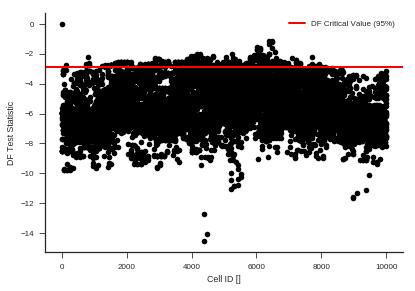

In [22]:
f = plt.figure()
plt.plot(arr_cellID, arr_test_statistic,'ko')
plt.axhline(y=arr_critical_value[-1], linewidth=2, color = 'red', label='DF Critical Value (95%)')
plt.legend()
plt.xlabel("Cell ID []")
plt.ylabel("DF Test Statistic")
sns.despine()

###Next Steps
Would be very interesting to perform a cross validation study and validate this model for internet usage with the remaining data collected in November and December 2014. This would help answer the question: does training a model with 1 week of internet usage data suffice? It would be nice to know. 

If you have other ideas please fork the notebook and continue the analysis! I would love to see what other models you can come up with....